# Preparing data

https://www.kaggle.com/code/mgmarques/houses-prices-complete-solution/notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_train=pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
print('train size={}'.format(data_train.shape))

data_test=pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')
print('train test={}'.format(data_test.shape))

train size=(1460, 81)
train test=(1459, 80)


# Summary

### Cleaning

* columns with > 0.90 missing values <br>['PoolQC', 'MiscFeature', 'Alley']

* most of the values present (see the 75 quantile below) in these variables are 0, thus these features can be cleared during the data preprocessing step.<br>
['BsmtFinSF2','LowQualFinSF','BsmtHalfBath','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

* imbalance classes big_class_ratio>=0.90<br>
['Street','Utilities','LandSlope','Condition2','RoofMatl','BsmtCond','Heating','CentralAir','Electrical','Functional','GarageQual','GarageCond','PavedDrive','MiscFeature']

* Highly correlated features r2>0.80 <br>
 'YearBuilt','GarageYrBlt'
 'GarageCars','GarageArea'
 'TotRmsAbvGrd','GrLivArea'
 'TotalBsmtSF','1stFlrSF'
* remap ordinally values for the columns 'KitchenQual','ExterQual','ExterCond','HeatingQC','FireplaceQu','BsmtQual'
 
### Feature engineering
* total house ares TotalSF=TotalBsmtSF+TotRmsAbvGrd+2ndFlrSF
* number of bathrooms =sum('FullBath'+'HalfBath'+'BsmtHalfBath'+'BsmtFullBath')

### Clean Outliers

# Cleaning

In [3]:
################################################################
## Cleaning
################################################################
def clean_suspicious_columns(data):
    empty_columns=['PoolQC','MiscFeature','Alley','Fence']
    lot_of_zeros=['BsmtFinSF2','LowQualFinSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
    imbalance_classes=['Street','Utilities','LandSlope','Condition2','RoofMatl','BsmtCond','Heating','CentralAir','Electrical','Functional','GarageQual','GarageCond','PavedDrive','MiscFeature']
    correlated_features=['GarageYrBlt','GarageArea','GrLivArea','1stFlrSF']
    
    drop_columns=empty_columns+lot_of_zeros+imbalance_classes+correlated_features
    data_clean_column=data.drop(drop_columns,axis=1)
    return data_clean_column

def remap_nan_to_none(data):
    # NA for Basement section means no basement in the house
    values = {"BsmtQual": 'None', "BsmtCond": 'None',"BsmtFinType1":'None',"BsmtFinType2":'None',"BsmtExposure":'None'}
    data_remap=data.fillna(value=values)

    # NA in 'FireplaceQu' means no FirePlace in the house (missing ratio 0.486468)
    data_remap.fillna(value={"FireplaceQu":'None'},inplace=True)

    # NA for Garage section means no Garage in the house (0.054471)
    values = {"GarageType": 'None', "GarageFinish":'None',"GarageQual":'None',"GarageCond":'None'}
    data_remap.fillna(value=values,inplace=True)
    return data_remap


def remap_ordinalcolumns(data):
    qual_dict={'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
    data_ord=data.copy()

    column_list_remap=['KitchenQual','ExterQual','ExterCond','HeatingQC','FireplaceQu','BsmtQual']
    for col in column_list_remap:
        data_ord[col]=data_ord[col].map(qual_dict)
    
    dict_lot_shape={'Reg':3,'IR1':2,'IR2':1,'IR3':0}
    data_ord['LotShape']=data_ord['LotShape'].map(dict_lot_shape)
    
    data_ord['MSSubClass']=data_ord['MSSubClass'].astype('object')
    return data_ord

In [4]:
data_train_cl1=clean_suspicious_columns(data_train)
data_test_cl1=clean_suspicious_columns(data_test)

data_train_cl2=remap_nan_to_none(data_train_cl1)
data_test_cl2=remap_nan_to_none(data_test_cl1)

# replace 'LotFrontage' NA with median value (0.166495)
Median=np.nanmedian(data_train_cl2['LotFrontage'])
data_train_cl3=data_train_cl2.fillna(value={'LotFrontage':Median})
data_test_cl3=data_test_cl2.fillna(value={'LotFrontage':Median})

# left features with missing ratio (0.005)
data_train_cl4=data_train_cl3.dropna()
data_test_cl4=data_test_cl3.dropna()

data_train_cl5=remap_ordinalcolumns(data_train_cl4)
data_test_cl5=remap_ordinalcolumns(data_test_cl4)

# Feature engineering

In [5]:
def feature_engineer(data):
    data_eng=data.copy()
    data_eng['Time_From_Remodel']=data_eng['YrSold']-data_eng['YearRemodAdd']
    ## strange remodeled early than built
    data_eng.drop(data_eng[data_eng['Time_From_Remodel']<0].index,inplace=True)

    data_eng['TotalSF']=data_eng['TotalBsmtSF']+data_eng['TotRmsAbvGrd']+data_eng['2ndFlrSF']
    data_eng['TotalBaths']=data_eng['FullBath']+data_eng['HalfBath']+data_eng['BsmtHalfBath']+data_eng['BsmtFullBath']
    return data_eng

In [6]:
data_train_6=feature_engineer(data_train_cl5)
data_test_6=feature_engineer(data_test_cl5)

In [7]:
data_test_6.shape

(1431, 55)

## Deal with outliers

(1451, 35)


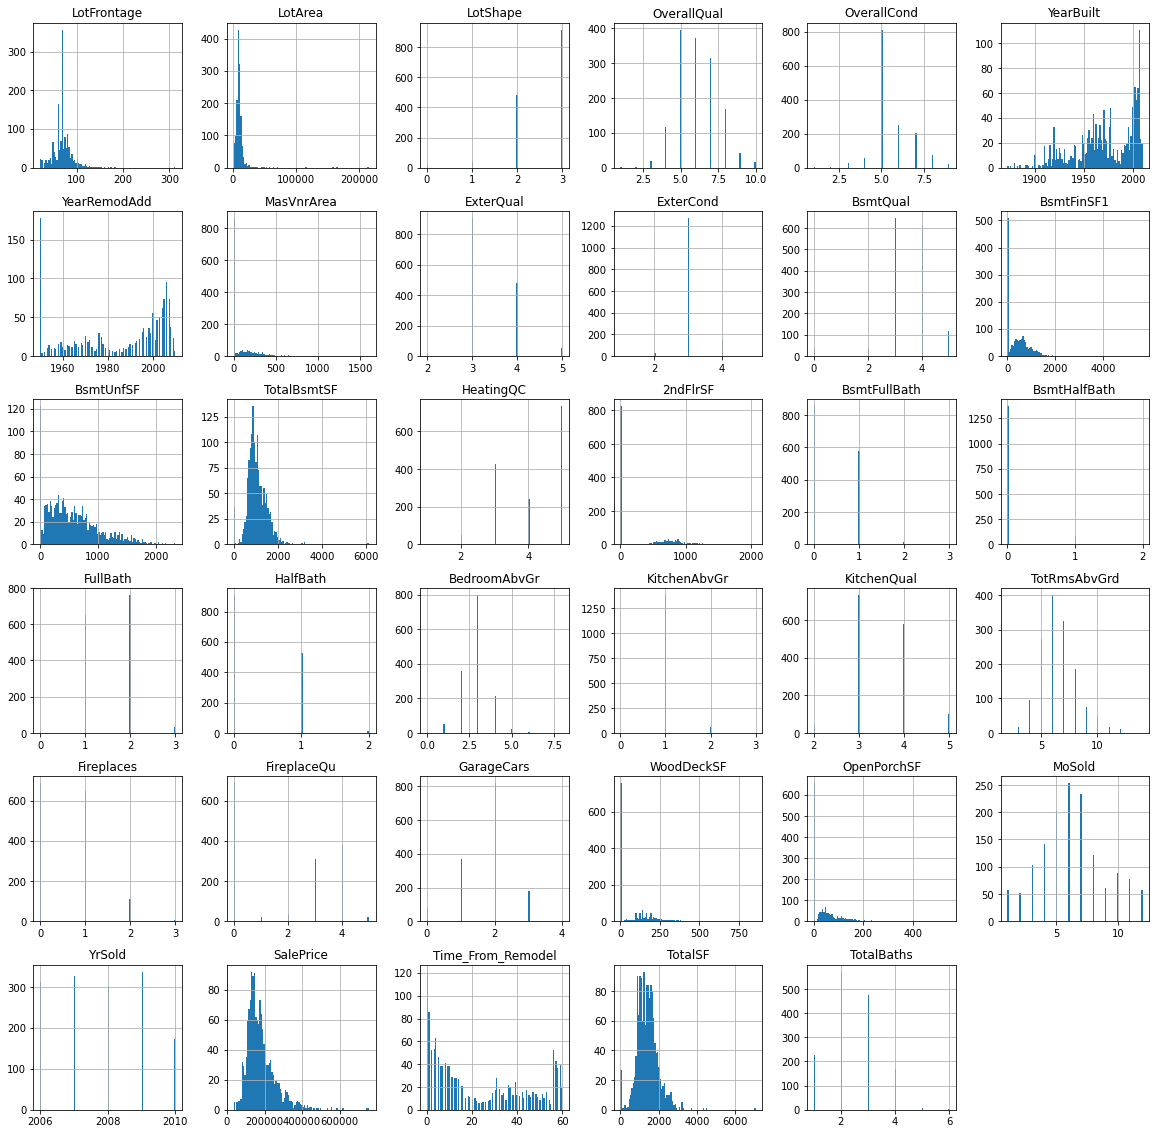

In [8]:
Numeric_data=data_train_6.select_dtypes(include=np.number).drop(columns='Id')
print(Numeric_data.shape)

Numeric_data.hist(bins=100,figsize=(20,20));

In [11]:
for col in Numeric_data.columns:
    # avoiding tripping discrete variables
    counts_category=data_train_6[col].value_counts().shape[0]
    print(col,counts_category)
    
    if counts_category>100:
        high_value=(data_train_6[col].quantile(0.99))
        selector=(data_train_6[col]<high_value)
        data_train_6=data_train_6.loc[selector]
        
print(data_train_6.shape)      

LotFrontage 110
LotArea 1051
LotShape 4
OverallQual 10
OverallCond 9
YearBuilt 112
YearRemodAdd 61
MasVnrArea 317
ExterQual 4
ExterCond 5
BsmtQual 5
BsmtFinSF1 607
BsmtUnfSF 747
TotalBsmtSF 662
HeatingQC 5
2ndFlrSF 391
BsmtFullBath 4
BsmtHalfBath 3
FullBath 4
HalfBath 3
BedroomAbvGr 7
KitchenAbvGr 4
KitchenQual 4
TotRmsAbvGrd 11
Fireplaces 4
FireplaceQu 6
GarageCars 5
WoodDeckSF 248
OpenPorchSF 184
MoSold 12
YrSold 5
SalePrice 576
Time_From_Remodel 61
TotalSF 804
TotalBaths 5
(1276, 56)


In [12]:
data_train_6.to_csv('../data/train_cleaned_2.csv',index=False)
data_test_6.to_csv('../data/test_cleaned_2.csv',index=False)